In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Теперь данные методы можно импортировать из этого модуля.

In [3]:
from statsmodels.tsa.arima.model import ARIMA

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [6]:
df = pd.read_csv('Series/international-airline-passengers.csv')
series = df['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


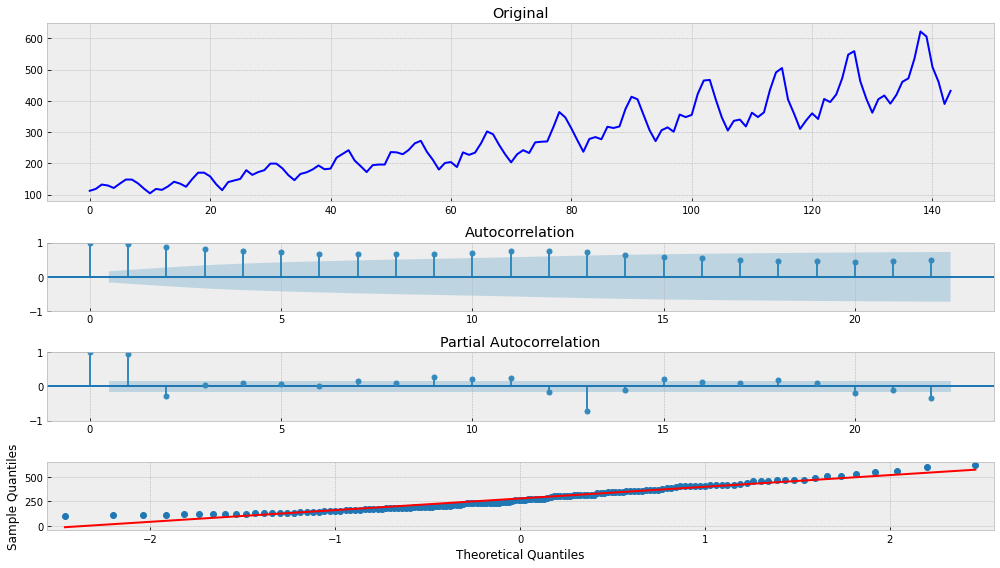

In [7]:
tsplot(series)

#### Видим, что наш временной ряд имеет и тренд, и сезонность. Используем модель ARIMA с дифференцированием. Однако потом попробуем дифференцировать заранее и использовать ARMA.

#### С method больше не порабоать, такого гиперпараметра нет в методе: https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html

In [8]:
model = ARIMA(series, order=(3, 1, 3), trend='n').fit()

#### Будем работать со значениями по умолчанию

In [9]:
model = ARIMA(series, order=(3, 1, 3)).fit()

In [10]:
print(model.aic)
print(model.params)

1345.9270978713926
ar.L1       1.006812
ar.L2       0.170243
ar.L3      -0.625530
ma.L1      -0.939910
ma.L2      -0.674515
ma.L3       0.893628
sigma2    620.666218
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -4.529546
p-value                          0.000174
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


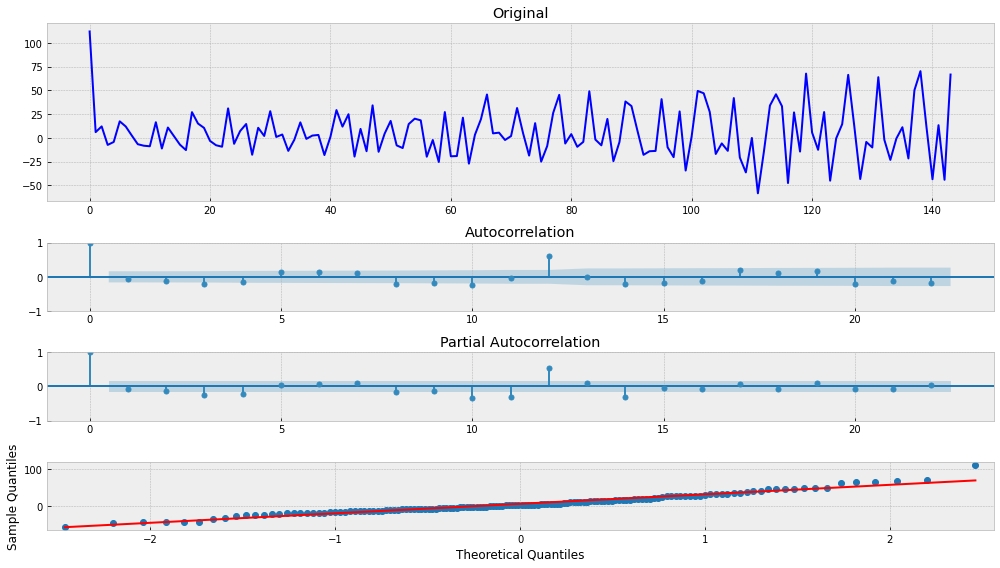

In [11]:
tsplot(model.resid)

In [12]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  144
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -665.964
Date:                Thu, 13 Jan 2022   AIC                           1345.927
Time:                        22:25:34   BIC                           1366.667
Sample:                             0   HQIC                          1354.355
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0068      0.160      6.300      0.000       0.694       1.320
ar.L2          0.1702      0.257      0.661      0.508      -0.334       0.675
ar.L3         -0.6255      0.153     -4.101      0.0

#### Подберем параметры p, d, q

In [13]:
def best_ARIMA_estimator(series, p=(1,5), d=(1,5), q=(1,5)):
    best_aic = np.inf
    best_order = None
    best_model = None

    for i in range(p[0], p[1]):
        for j in range(d[0], d[1]):
            for k in range(q[0], q[1]):
                model = ARIMA(series, order=(i, j, k), trend='n').fit()
                current_aic = model.aic
                print('aic: {:6.5f} | order: {}'.format(current_aic, (i, j, k)))
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_order = (i, j, k)
                    best_model = model

    print('-----')
    print('best_aic: {:6.5f} | best_order: {}'.format(best_aic, best_order))

In [14]:
best_ARIMA_estimator(series, (1,5), (1,5), (1,5))

aic: 1394.68251 | order: (1, 1, 1)
aic: 1385.49755 | order: (1, 1, 2)
aic: 1386.89221 | order: (1, 1, 3)
aic: 1373.78877 | order: (1, 1, 4)
aic: 1398.92840 | order: (1, 2, 1)
aic: 1391.90847 | order: (1, 2, 2)
aic: 1392.46761 | order: (1, 2, 3)
aic: 1394.21830 | order: (1, 2, 4)
aic: 1445.16244 | order: (1, 3, 1)
aic: 1448.77027 | order: (1, 3, 2)
aic: 1407.25612 | order: (1, 3, 3)
aic: 1400.29861 | order: (1, 3, 4)
aic: 1521.86542 | order: (1, 4, 1)
aic: 1448.27611 | order: (1, 4, 2)
aic: 1453.85063 | order: (1, 4, 3)
aic: 1415.91118 | order: (1, 4, 4)
aic: 1378.33832 | order: (2, 1, 1)
aic: 1353.34664 | order: (2, 1, 2)
aic: 1385.55053 | order: (2, 1, 3)
aic: 1362.27371 | order: (2, 1, 4)
aic: 1393.88657 | order: (2, 2, 1)
aic: 1392.65689 | order: (2, 2, 2)
aic: 1394.42980 | order: (2, 2, 3)
aic: 1371.22705 | order: (2, 2, 4)
aic: 1438.72039 | order: (2, 3, 1)
aic: 1437.23355 | order: (2, 3, 2)
aic: 1404.03411 | order: (2, 3, 3)
aic: 1400.96477 | order: (2, 3, 4)
aic: 1498.15040 | or

#### Видим, что лучшими параметрами являются (4, 1, 4), продолжим подбор с константным значением d = 1

In [15]:
best_ARIMA_estimator(series, (5, 8), (1,2), (5,8))

aic: 1335.11918 | order: (5, 1, 5)
aic: 1327.27703 | order: (5, 1, 6)
aic: 1330.83610 | order: (5, 1, 7)
aic: 1333.43889 | order: (6, 1, 5)
aic: 1310.69858 | order: (6, 1, 6)
aic: 1324.37397 | order: (6, 1, 7)
aic: 1321.60603 | order: (7, 1, 5)
aic: 1314.44227 | order: (7, 1, 6)
aic: 1315.61308 | order: (7, 1, 7)
-----
best_aic: 1310.69858 | best_order: (6, 1, 6)


In [16]:
model = ARIMA(series, order=(6, 1, 6), trend='n').fit()

In [17]:
print(model.aic)
print(model.params)

1310.6985790604917
ar.L1       2.326744
ar.L2      -3.332014
ar.L3       3.173377
ar.L4      -2.525194
ar.L5       1.472341
ar.L6      -0.662390
ma.L1      -2.581957
ma.L2       3.695389
ma.L3      -3.901436
ma.L4       3.593452
ma.L5      -2.238750
ma.L6       0.707794
sigma2    557.367997
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -4.214501
p-value                          0.000623
#Lags Used                      11.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


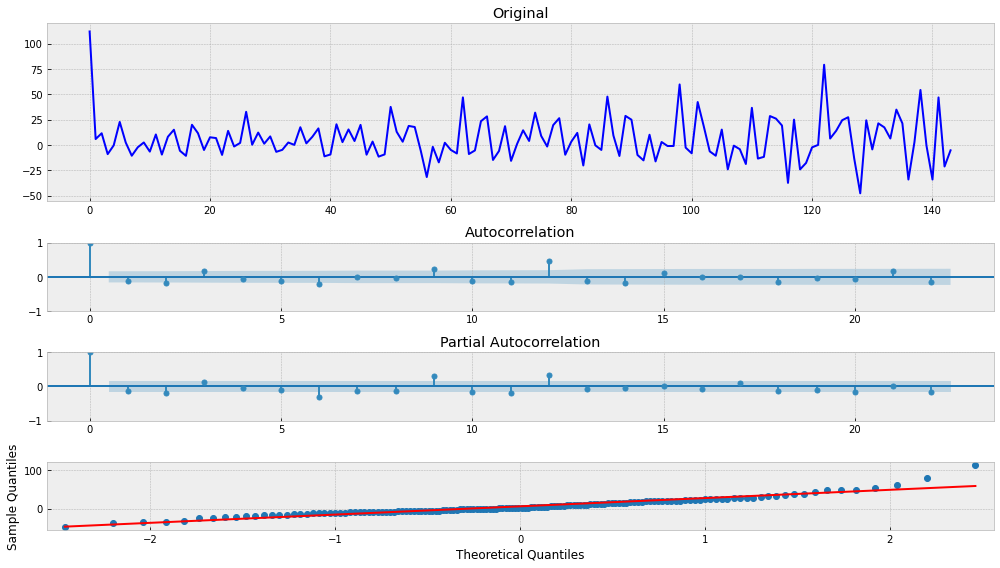

In [18]:
tsplot(model.resid)

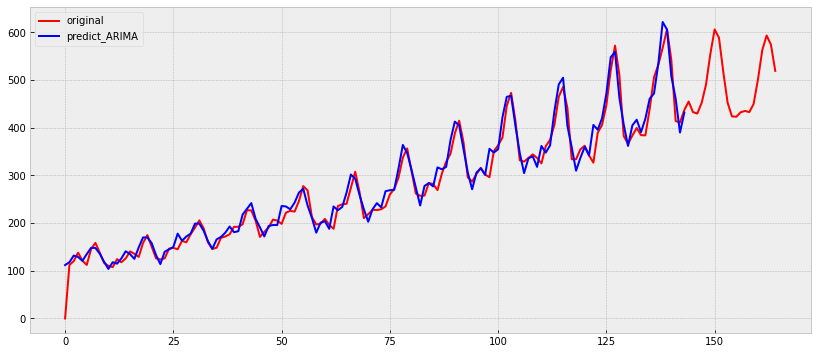

In [19]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 6))
    plt.plot(model.predict(start=0, end=164), color='red', label='original')
    plt.plot(series, color='blue', label='predict_ARIMA')
    plt.legend()

#### Получились довольно неплохие результаты, если не пронозировать далеко

#### Пробуем ARMA на уже продифференцированном временном ряде

In [20]:
series_1 = np.diff(series, 1)

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


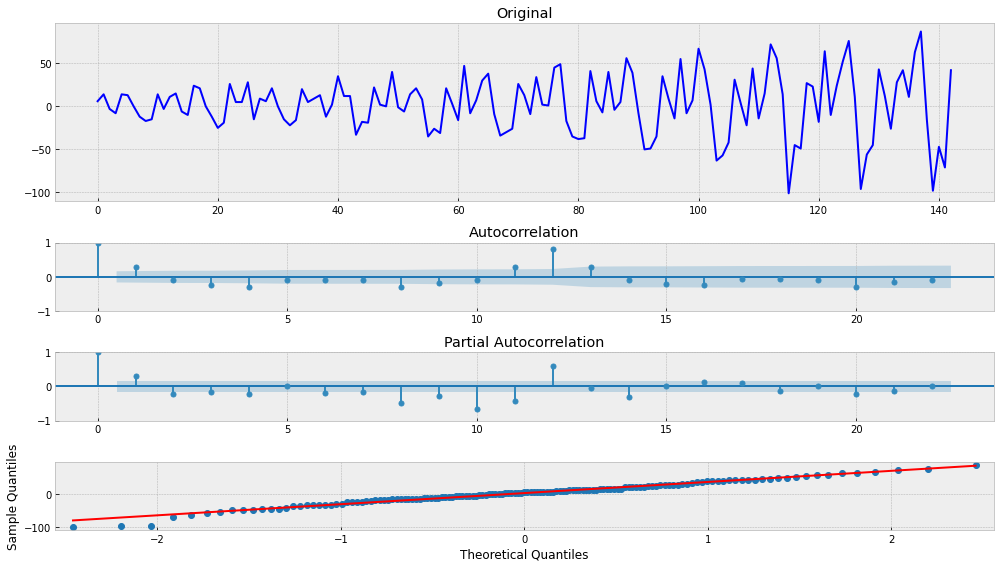

In [21]:
tsplot(series_1)

#### Как мне удалось выяснить, модели AR и ARMA включены в модель ARIMA модуля from statsmodels.tsa.arima.model import ARIMA. По другому использовать ARMA не выходит

#### Поправьте меня, если не правильно уловил мысль, но для использвования ARMA мы просто передаем d=0.

In [22]:
model_arma = ARIMA(series_1, order=(5, 0, 5), trend='n').fit()

In [23]:
print(model_arma.aic)
print(model_arma.params)

1334.1411652355364
[ 5.11614200e-01 -8.29682416e-02  4.19510670e-01 -4.78237129e-01
 -1.73975781e-01 -4.26203173e-01 -2.91624911e-01 -6.43477711e-01
 -2.99068495e-02  8.20392574e-01  5.45505047e+02]


In [24]:
print(model_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  143
Model:                 ARIMA(5, 0, 5)   Log Likelihood                -656.071
Date:                Thu, 13 Jan 2022   AIC                           1334.141
Time:                        22:27:05   BIC                           1366.732
Sample:                             0   HQIC                          1347.385
                                - 143                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5116      0.170      3.008      0.003       0.178       0.845
ar.L2         -0.0830      0.148     -0.562      0.574      -0.372       0.207
ar.L3          0.4195      0.149      2.822      0.0

Results of Dickey-Fuller Test:
Test Statistic                  -4.181933
p-value                          0.000707
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


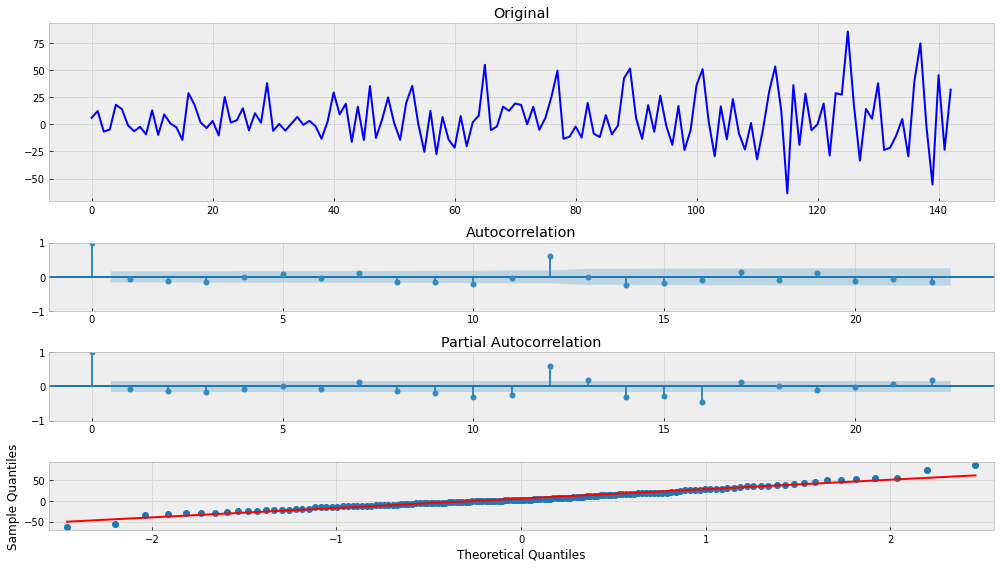

In [25]:
tsplot(model_arma.resid)

In [26]:
def best_ARMA_estimator(series, p=(1,5), q=(1,5)):
    best_aic = np.inf
    best_order = None
    best_model = None

    for i in range(p[0], p[1]):
        for j in range(q[0], q[1]):
            model = ARIMA(series, order=(i, 0, j), trend='n').fit()
            current_aic = model.aic
            print('aic: {:6.5f} | order: {}'.format(current_aic, (i, j)))
            if current_aic < best_aic:
                best_aic = current_aic
                best_order = (i, j)
                best_model = model

    print('-----')
    print('best_aic: {:6.5f} | best_order: {}'.format(best_aic, best_order))

In [27]:
best_ARMA_estimator(series_1)

aic: 1394.68320 | order: (1, 1)
aic: 1385.49680 | order: (1, 2)
aic: 1386.89154 | order: (1, 3)
aic: 1373.78992 | order: (1, 4)
aic: 1378.33802 | order: (2, 1)
aic: 1353.34575 | order: (2, 2)
aic: 1385.55053 | order: (2, 3)
aic: 1362.06421 | order: (2, 4)
aic: 1379.61400 | order: (3, 1)
aic: 1377.08654 | order: (3, 2)
aic: 1345.94771 | order: (3, 3)
aic: 1351.37369 | order: (3, 4)
aic: 1384.05425 | order: (4, 1)
aic: 1373.56061 | order: (4, 2)
aic: 1365.82536 | order: (4, 3)
aic: 1342.37898 | order: (4, 4)
-----
best_aic: 1342.37898 | best_order: (4, 4)


#### Попробуем еще немного пройтись

In [28]:
best_ARMA_estimator(series_1, (3, 7), (3, 7))

aic: 1345.94771 | order: (3, 3)
aic: 1351.37369 | order: (3, 4)
aic: 1364.19403 | order: (3, 5)
aic: 1354.70572 | order: (3, 6)
aic: 1365.82536 | order: (4, 3)
aic: 1342.37898 | order: (4, 4)
aic: 1344.61869 | order: (4, 5)
aic: 1331.71878 | order: (4, 6)
aic: 1367.34749 | order: (5, 3)
aic: 1367.08735 | order: (5, 4)
aic: 1334.14117 | order: (5, 5)
aic: 1328.17092 | order: (5, 6)
aic: 1322.04672 | order: (6, 3)
aic: 1324.53389 | order: (6, 4)
aic: 1333.33161 | order: (6, 5)
aic: 1303.11214 | order: (6, 6)
-----
best_aic: 1303.11214 | best_order: (6, 6)


In [29]:
model_arma = ARIMA(series_1, order=(6, 0, 6), trend='n').fit()

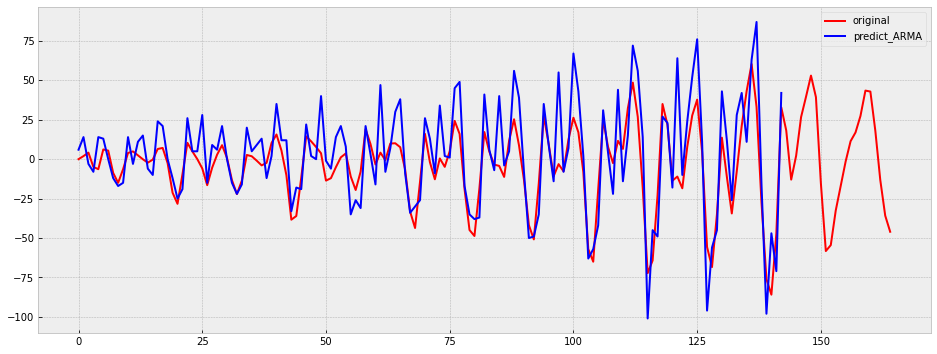

In [30]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 6))
    plt.plot(model_arma.predict(start=0, end=164), color='red', label='original')
    plt.plot(series_1, color='blue', label='predict_ARMA')
    plt.legend()

#### Получилось весьма не дурно

### Классический ML

In [31]:
df = pd.read_csv("Series/international-airline-passengers.csv")

In [32]:
def prepareData(data, lag_start=1, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return data, X_train, X_test, y_train, y_test

In [33]:
data, x_train, x_test, y_train, y_test = prepareData(df, test_size=0.3)

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
model_lin = LinearRegression()
model_lin.fit(x_train, y_train)
pred_lin_model = model_lin.predict(x_test)

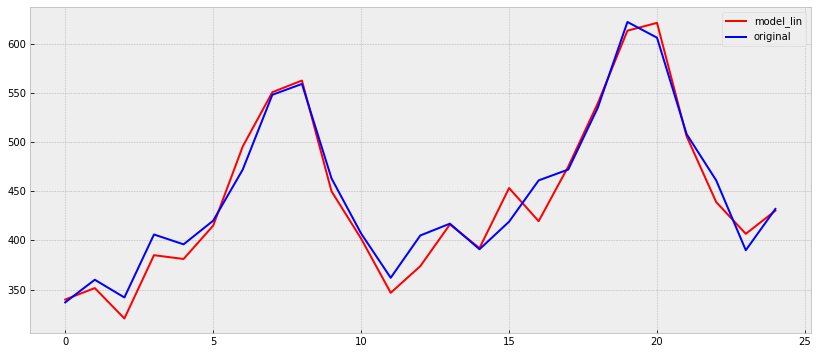

In [36]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,6))
    plt.plot(pred_lin_model, color='red', label='model_lin')
    plt.plot(y_test.values, color='blue', label='original')
    plt.legend()

In [37]:
predict_all = model_lin.predict(data.drop(['Count'], axis=1))

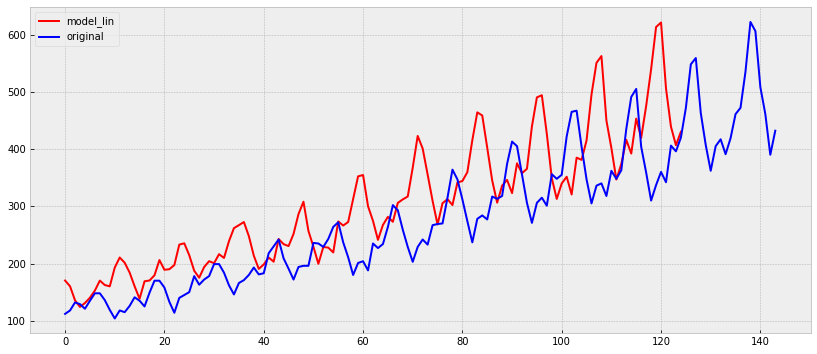

In [38]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,6))
    plt.plot(predict_all, color='red', label='model_lin')
    plt.plot(df['Count'], color='blue', label='original')
    plt.legend()

#### Попробуем на рандомных деревьях

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [40]:
params = {'n_estimators':[10,25,50,100,150,200],
          'criterion':['squared_error', 'absolute_error', 'poisson'], 'max_depth':[3,5,7,9,11]}

In [41]:
RF = RandomForestRegressor()

In [42]:
rgrid = RandomizedSearchCV(RF, params, cv=5, scoring='accuracy')

In [43]:
rgrid.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [3, 5, 7, 9, 11],
                                        'n_estimators': [10, 25, 50, 100, 150,
                                                         200]},
                   scoring='accuracy')

In [44]:
print(rgrid.best_score_)
print(rgrid.best_estimator_)
print(rgrid.best_params_)

nan
RandomForestRegressor(criterion='poisson', max_depth=9)
{'n_estimators': 100, 'max_depth': 9, 'criterion': 'poisson'}


In [45]:
model_rf = rgrid.best_estimator_

In [46]:
pred_rf = model_rf.predict(x_test)


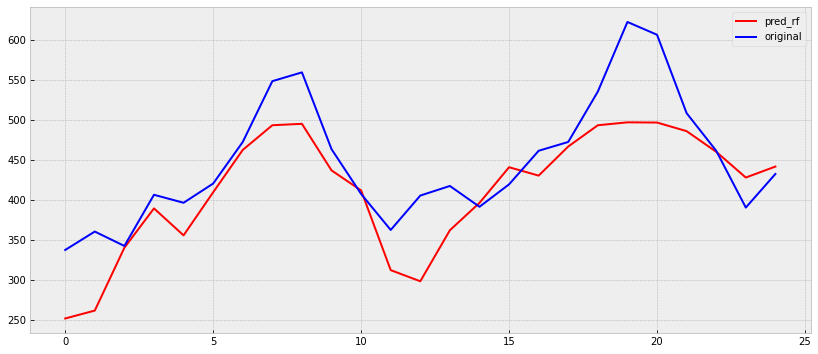

In [47]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,6))
    plt.plot(pred_rf, color='red', label='pred_rf')
    plt.plot(y_test.values, color='blue', label='original')
    plt.legend()

#### Видим, что Рандомные деревья справились хуже, чем линейная модель. Попробуем поподбирать гиперпараметры на лийнейных моделях

In [48]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from scipy.stats import uniform

In [49]:
models=[ 
      {'name':'Lr',"model": LinearRegression()  , 'params':{'fit_intercept':[True, False], 'normalize':[True, False]}},
      {'name':'R',"model": Ridge(), 'params':{'alpha': uniform(loc=0, scale=4), 'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}},
      {'name':'L',"model": Lasso(), 'params':{'alpha': uniform(loc=0, scale=4), 'selection':['cyclic', 'random']}}
]

In [50]:
res=[]
for v in  models:
    res.append((v['name'], RandomizedSearchCV(v['model'], v['params'], cv=10).fit(x_train, y_train)))
    
for r in res:
    print(r[0], r[1].best_score_, r[1].best_params_)

Lr 0.8640378770793447 {'normalize': False, 'fit_intercept': True}
R 0.8733516086065279 {'alpha': 0.6997792782139793, 'solver': 'sag'}
L 0.871288224150832 {'alpha': 1.9918649613999224, 'selection': 'random'}


In [51]:
best_model = res[1][1].best_estimator_

In [52]:
best_model_pred = best_model.predict(x_test)

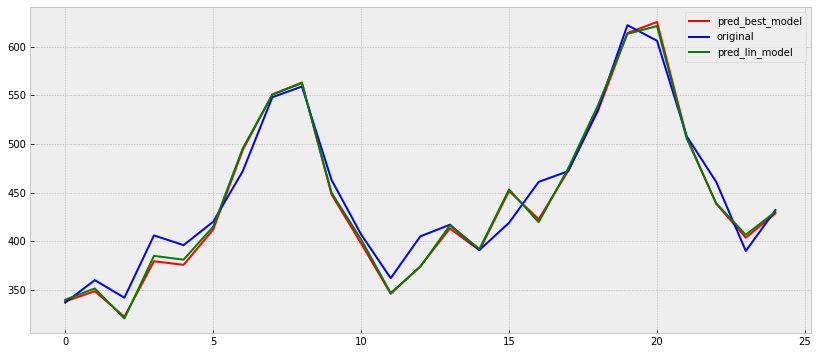

In [53]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,6))
    plt.plot(best_model_pred, color='red', label='pred_best_model')
    plt.plot(y_test.values, color='blue', label='original')
    plt.plot(pred_lin_model, color='green', label='pred_lin_model')
    plt.legend()

#### Можем увидеть, что Линейная модель и без подбора параметров справилась отлично

#### Попробуем спрогнозировать несколько значений с помощью классического ML

In [54]:
def predict_new_values(dataset, n_pred, model, y='Count'):
    data = dataset.copy()
    
    # Берем названия всех наших столбцов (не считая целевую переменную), длина списка даст нам количетсво предыдущих значений  
    columns=list(data.columns)
    columns.remove(y)
    amount_col = len(columns)
    
    # Предсказываем n_pred новых значений временного ряда 
    for i in range(n_pred):
        # Получаем N предыдущих значений         
        new_sample = data.iloc[-amount_col:][y].values
        
        # Присоединяем их в конец нашего датасета
        new_row = pd.DataFrame([new_sample], columns=columns)
        data = data.append(new_row, ignore_index=True)
        
        # Предсказываем новое значение  
        value_for_predict = data.iloc[-1:].drop([y], axis=1)
        new_value = model.predict(value_for_predict)

        # Заменяем Nan нового значения на предсказанное     
        data[y] = data[y].fillna(new_value[0])
        
    return data

In [55]:
predict_data = predict_new_values(data, 4, best_model, y='Count')

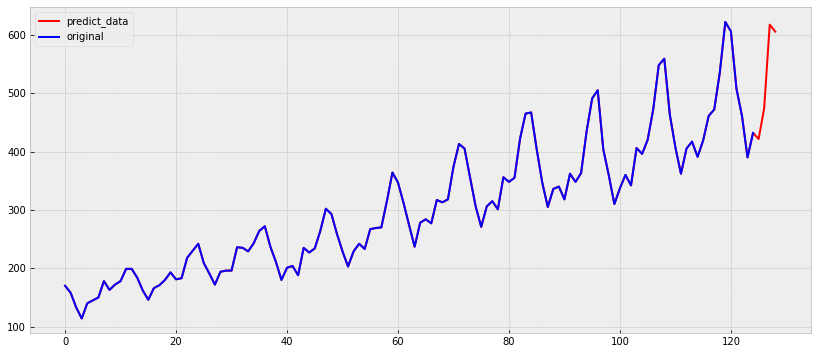

In [56]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,6))
    plt.plot(predict_data['Count'], color='red', label='predict_data')
    plt.plot(data['Count'], color='blue', label='original')
    plt.legend()

#### Если не прогнозировать на длительный срок, то получается вполне рабочая модель